In [1]:
prefix="../../h2o-3"
import sys
sys.path.append(prefix + "/h2o-py/build/main")
import h2o
from h2o.estimators import H2OAdaBoostEstimator, H2OGradientBoostingEstimator
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

versionFromGradle='3.43.0',projectVersion='3.43.0.99999',branch='valenad-6723-adaboost-API',lastCommitHash='d58b1c3ef068a0feec1c49661dd49e9279b33d68',gitDescribe='jenkins-master-6264-18-gd58b1c3ef0',compiledOn='2023-09-11 15:31:47',compiledBy='potte'


In [2]:
# Notebook parameters

seed = 1234
n_estimators = 50
attempt_per_thread = 5 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]

In [3]:
def train_models(nthreads, file, target):
    h2o.init(nthreads=nthreads)
    train = h2o.import_file(file)
    train[target] = train[target].asfactor()
    global N
    N = train.shape[0]
    global P 
    P = train.shape[1]
    start = time.time()
    adaBoost_h2o = H2OAdaBoostEstimator(model_id = "adaboost.hex",
                                         n_estimators = n_estimators, seed = seed)
    adaBoost_h2o.train(training_frame = train, y=target)
    end = time.time()
    adaboost_time = end - start
    print(f"AdaBoost Time: {adaboost_time}s")
    start = time.time()
    gbm_h2o = H2OGradientBoostingEstimator(model_id = "adaboost.hex",
                                         ntrees = n_estimators, max_depth=2, score_tree_interval=n_estimators+1)
    gbm_h2o.train(training_frame = train, y=target)
    end = time.time()
    gbm_time = end - start
    print(f"GBM Time: {gbm_time}s")    
    h2o.cluster().shutdown()
    time.sleep(3)
    return adaboost_time, gbm_time


def run_benchmark(file, target):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        for i in range(attempt_per_thread):
            eif_time, if_time = train_models(nthreads, file, target)
            times_eif.append(eif_time)
            times_if.append(if_time)
        print(f"AdaBoost {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - AdaBoost {np.mean(times_eif)}s and GBM {np.mean(times_if)}s")

    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - AdaBoost = {np.mean(all_times_num_eif[i])}, GBM = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])
    
    return eif_means, if_means
        
    
def plot_result(eif_means, if_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="AdaBoost", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"AdaBoost - training benchmark\nModel: N = {N}; P = {P}; n_estimatos = {n_estimators};")
    plt.savefig(f"h2o-scale-perf_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [4]:
adaboost_time, gbm_time = run_benchmark(prefix + "/smalldata/prostate/prostate.csv", "CAPSULE")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfexg42b1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfexg42b1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfexg42b1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_potte_5agkxt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9550487995147705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2629077434539795s
H2O session _sid_baa1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj7q9z0k2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj7q9z0k2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj7q9z0k2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,42 minutes
H2O_cluster_name:,H2O_from_python_potte_kznzh0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9708466529846191s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2626049518585205s
H2O session _sid_9328 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi_gc1ixt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi_gc1ixt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi_gc1ixt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_hgxonr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9395885467529297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.27863049507141113s
H2O session _sid_a3a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfmz3ngou
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfmz3ngou\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfmz3ngou\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_owd0gq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9482395648956299s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.3007535934448242s
H2O session _sid_80ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6vzd4gtm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6vzd4gtm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6vzd4gtm\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_anb04u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9642989635467529s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2850480079650879s
H2O session _sid_a2ae closed.
AdaBoost 0.9556045055389404s
IF 0.27798895835876464s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3em58lfi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3em58lfi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3em58lfi\h2o_potte_started_from_python.err
  Server is running at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_pbjh2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9330940246582031s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2852010726928711s
H2O session _sid_9860 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpinpdnisx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpinpdnisx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpinpdnisx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_gunjcy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9546244144439697s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2785916328430176s
H2O session _sid_926a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqwhjf5rp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqwhjf5rp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqwhjf5rp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_wc3lqf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9333665370941162s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2851603031158447s
H2O session _sid_b46c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr7v65r67
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr7v65r67\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr7v65r67\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_svz3jz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9641382694244385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2851290702819824s
H2O session _sid_a74b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyms_7x8q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyms_7x8q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyms_7x8q\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_829y79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.6860203742980957s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5241210460662842s
H2O session _sid_8b09 closed.
AdaBoost 1.0942487239837646s
IF 0.331640625s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg5jaf07r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg5jaf07r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg5jaf07r\h2o_potte_started_from_python.err
  Server is running at http://

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_fi5w6a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.3841397762298584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2848076820373535s
H2O session _sid_ac2f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwxjj0p9t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwxjj0p9t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwxjj0p9t\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_r3su1t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.4177277088165283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.5288288593292236s
H2O session _sid_be4c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnz_tjizw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnz_tjizw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnz_tjizw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_pq12mq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.4053516387939453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2901618480682373s
H2O session _sid_8c1d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvaz70t99
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvaz70t99\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvaz70t99\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_y1t9f0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.168292760848999s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.28299808502197266s
H2O session _sid_80bd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1bz_4eyz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1bz_4eyz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1bz_4eyz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_xqsxkv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1659560203552246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.31594371795654297s
H2O session _sid_a922 closed.
AdaBoost 1.3082935810089111s
IF 0.340548038482666s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb74p6b52
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb74p6b52\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb74p6b52\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_886jiu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.4335253238677979s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.31603288650512695s
H2O session _sid_aacd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg2pa8_9r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg2pa8_9r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg2pa8_9r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,50 minutes
H2O_cluster_name:,H2O_from_python_potte_jm5o2t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1804578304290771s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2850987911224365s
H2O session _sid_8b2a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfu7xd63r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfu7xd63r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfu7xd63r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,50 minutes
H2O_cluster_name:,H2O_from_python_potte_ghj3li
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9596846103668213s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.3007216453552246s
H2O session _sid_bdbc closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp35m6n1ur
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp35m6n1ur\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp35m6n1ur\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_gh2lmr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1651389598846436s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.3159451484680176s
H2O session _sid_bb14 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxki0s1jp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxki0s1jp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxki0s1jp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_tiqb62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1702871322631836s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2691357135772705s
H2O session _sid_abb0 closed.
AdaBoost 1.1818187713623047s
IF 0.29738683700561525s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0dqp3cyz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0dqp3cyz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0dqp3cyz\h2o_potte_started_from_python.err
  Server is running at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_k33hfd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1804635524749756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.3007211685180664s
H2O session _sid_9b42 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqxczrr5d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqxczrr5d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqxczrr5d\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_orkt42
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.18442964553833s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.3007323741912842s
H2O session _sid_b196 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp62ai7y0r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp62ai7y0r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp62ai7y0r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_xw1oni
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1339147090911865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.28502917289733887s
H2O session _sid_adeb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzm3012vf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzm3012vf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzm3012vf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_lglstg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.138317584991455s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.28254103660583496s
H2O session _sid_a8df closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy0v8zrwp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy0v8zrwp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy0v8zrwp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_vn8fgs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1827354431152344s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.27887797355651855s
H2O session _sid_904c closed.
AdaBoost 1.1639721870422364s
IF 0.2895803451538086s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph0vk8_n9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph0vk8_n9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph0vk8_n9\h2o_potte_started_from_python.err
  Server is running at

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_potte_cplitf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9324216842651367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2850980758666992s
H2O session _sid_bab4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi1mx7m88
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi1mx7m88\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi1mx7m88\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_potte_4345iz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9869675636291504s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.27574586868286133s
H2O session _sid_a6f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgo0gdtqq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgo0gdtqq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgo0gdtqq\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_bt6ijr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9812047481536865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2785964012145996s
H2O session _sid_a4a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1rb2f0za
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1rb2f0za\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1rb2f0za\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_039zet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9837172031402588s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2864987850189209s
H2O session _sid_9306 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc2c7nyvf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc2c7nyvf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc2c7nyvf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_2gudey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.2242438793182373s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2822115421295166s
H2O session _sid_bfec closed.
AdaBoost 1.0217110157012939s
IF 0.2816301345825195s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxn6swva7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxn6swva7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxn6swva7\h2o_potte_started_from_python.err
  Server is running at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_eh5rkn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1433541774749756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2894864082336426s
H2O session _sid_98ed closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvh62a67r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvh62a67r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvh62a67r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_ynlv9y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.1814956665039062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.27944493293762207s
H2O session _sid_894c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpic8al57l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpic8al57l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpic8al57l\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_69xmdg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.0040979385375977s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.26777052879333496s
H2O session _sid_8697 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp70fi2jhd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp70fi2jhd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp70fi2jhd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_potte_8xul3k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 1.0170695781707764s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.2793848514556885s
H2O session _sid_a14a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwtwv8527
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwtwv8527\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwtwv8527\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,58 minutes
H2O_cluster_name:,H2O_from_python_potte_lyy7w3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 0.9948065280914307s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 0.28144288063049316s
H2O session _sid_abf1 closed.
AdaBoost 1.0681647777557373s
IF 0.27950592041015626s
12 - AdaBoost = 0.9556045055389404, GBM = 0.27798895835876464
10 - AdaBoost = 1.0942487239837646, GBM = 0.331640625
8 - AdaBoost = 1.3082935810089111, GBM = 0.340548038482666
6 - AdaBoost = 1.1818187713623047, GBM = 0.29738683700561525
4 - AdaBoost = 1.1639721870422364, GBM = 0.2895803451538086
2 - AdaBoost = 1.0217110157012939, GBM = 0.2816301345825195
1 - AdaBoost = 1.0681647777557373, GBM = 0.27950592041015626


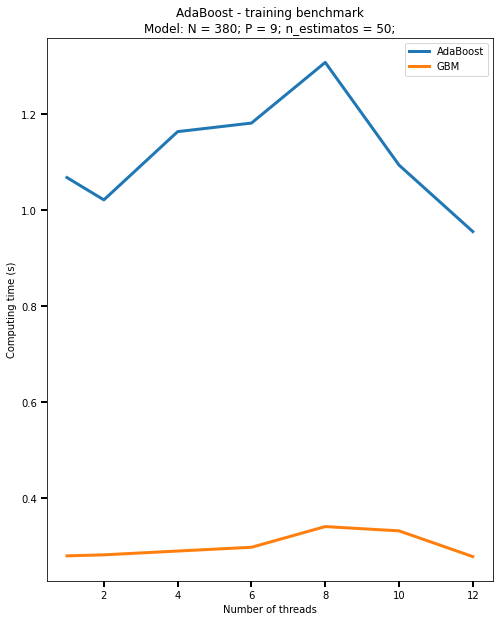

In [5]:
plot_result(adaboost_time, gbm_time)

In [6]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/higgs_head_2M.csv", "C1")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0l58evo2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0l58evo2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0l58evo2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_c4my9m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.83241891860962s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 12.26988172531128s
H2O session _sid_957b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaodgqzxa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaodgqzxa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaodgqzxa\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_potte_567jn7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.517481565475464s
gbm Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.432619333267212s
H2O session _sid_98ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyba9j2r5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyba9j2r5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyba9j2r5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_hs402h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.01394557952881s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.17983603477478s
H2O session _sid_8ae0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpun4cu_so
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpun4cu_so\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpun4cu_so\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_zjzh6m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.24433183670044s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.396578311920166s
H2O session _sid_87e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpng5klwlt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpng5klwlt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpng5klwlt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_6nkq0g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.29544448852539s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.650996923446655s
H2O session _sid_a296 closed.
AdaBoost 18.580724477767944s
IF 11.585982465744019s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpshlxuqvw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpshlxuqvw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpshlxuqvw\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_1marhc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.60609722137451s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.856656789779663s
H2O session _sid_ad17 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr98vpx4r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr98vpx4r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr98vpx4r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_k6ulue
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.82405924797058s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 12.246095657348633s
H2O session _sid_a1cf closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj6xnuyvc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj6xnuyvc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj6xnuyvc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_ctuua3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.386117219924927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.931361675262451s
H2O session _sid_8b1a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf2cspphd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf2cspphd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf2cspphd\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_m2zs8r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 17.321333169937134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 12.573169231414795s
H2O session _sid_93be closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx_rm8m72
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx_rm8m72\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx_rm8m72\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_369ex2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.92641282081604s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.795011281967163s
H2O session _sid_bedd closed.
AdaBoost 17.21280393600464s
IF 12.080458927154542s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4pdwcd85
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4pdwcd85\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4pdwcd85\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_zyehxo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.30428171157837s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.781732559204102s
H2O session _sid_b5c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfe_e6dwi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfe_e6dwi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfe_e6dwi\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_0v5t0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.1377911567688s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.821308851242065s
H2O session _sid_a901 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8j3y3sxr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8j3y3sxr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8j3y3sxr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_0lkcou
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 16.82051157951355s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 11.797731876373291s
H2O session _sid_bdb2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9p_541rs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9p_541rs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9p_541rs\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_hgg2ei
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.065485954284668s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.37091875076294s
H2O session _sid_9f31 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9hk1dzqn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9hk1dzqn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9hk1dzqn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_6k65jb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.30988311767578s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 13.281704664230347s
H2O session _sid_9dab closed.
AdaBoost 17.527590703964233s
IF 12.610679340362548s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkd2omgc3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkd2omgc3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkd2omgc3\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_ntsc0l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.020500659942627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.389598608016968s
H2O session _sid_9333 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfhp4wcbn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfhp4wcbn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfhp4wcbn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_yzwbvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.100383043289185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 13.881452798843384s
H2O session _sid_9637 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkkzoa4qw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkkzoa4qw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkkzoa4qw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_z69bny
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.970454931259155s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 13.657201528549194s
H2O session _sid_9c43 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc4utfi98
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc4utfi98\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc4utfi98\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_bbh0no
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.160658359527588s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.120980739593506s
H2O session _sid_9bd5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvp1smgv4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvp1smgv4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvp1smgv4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_xejveo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 18.71960186958313s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 13.76915168762207s
H2O session _sid_ba79 closed.
AdaBoost 18.99431977272034s
IF 14.163677072525024s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprxeyv9vl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprxeyv9vl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprxeyv9vl\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_q0s8v7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.106204748153687s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.93528127670288s
H2O session _sid_9494 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpif96qlm1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpif96qlm1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpif96qlm1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_lshayp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 21.130419731140137s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 16.09653091430664s
H2O session _sid_a641 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9_5kqb72
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9_5kqb72\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9_5kqb72\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_q31lqz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 22.33850121498108s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 15.862026691436768s
H2O session _sid_86af closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa3ly3lph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa3ly3lph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa3ly3lph\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_tqpebv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.212875604629517s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.126998662948608s
H2O session _sid_b41a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdfs1gph4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdfs1gph4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdfs1gph4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_8s1f7x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 19.21729302406311s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 14.003969669342041s
H2O session _sid_ae9b closed.
AdaBoost 20.601058864593504s
IF 15.204961442947388s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpema_s1iq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpema_s1iq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpema_s1iq\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_2d2dt7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.078920364379883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 23.700955390930176s
H2O session _sid_80e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvfn4t8g5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvfn4t8g5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvfn4t8g5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_adc6wz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 30.24876618385315s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 23.90292453765869s
H2O session _sid_9629 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0s3uqzz0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0s3uqzz0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0s3uqzz0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_8fq97q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.284376621246338s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.786771059036255s
H2O session _sid_a7ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjy1_ojr_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjy1_ojr_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjy1_ojr_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_u8hem6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.103442907333374s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 24.93644070625305s
H2O session _sid_a9fa closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyclzjg70
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyclzjg70\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyclzjg70\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_se8h2k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 31.550206899642944s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 25.84914207458496s
H2O session _sid_bf37 closed.
AdaBoost 30.85314259529114s
IF 24.635246753692627s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptu4m89w7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptu4m89w7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptu4m89w7\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_1zhbt2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 54.12187647819519s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 48.22014331817627s
H2O session _sid_a6e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppam57h5w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppam57h5w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppam57h5w\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_gc5pxu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |██████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 52.96289372444153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 47.351499795913696s
H2O session _sid_a8eb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9rz2pt0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9rz2pt0s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9rz2pt0s\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_6b0jqt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |██████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.69170904159546s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 44.738709688186646s
H2O session _sid_b352 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppnj0yv4v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppnj0yv4v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppnj0yv4v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_4n19d0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 50.13791346549988s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 43.69915723800659s
H2O session _sid_a9b8 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp4cw1dd_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp4cw1dd_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp4cw1dd_\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_s5b28z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 53.23474597930908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 47.20027947425842s
H2O session _sid_9667 closed.
AdaBoost 52.22982773780823s
IF 46.241957902908325s
12 - AdaBoost = 18.580724477767944, GBM = 11.585982465744019
10 - AdaBoost = 17.21280393600464, GBM = 12.080458927154542
8 - AdaBoost = 17.527590703964233, GBM = 12.610679340362548
6 - AdaBoost = 18.99431977272034, GBM = 14.163677072525024
4 - AdaBoost = 20.601058864593504, GBM = 15.204961442947388
2 - AdaBoost = 30.85314259529114, GBM = 24.635246753692627
1 - AdaBoost = 52.22982773780823, GBM = 46.241957902908325


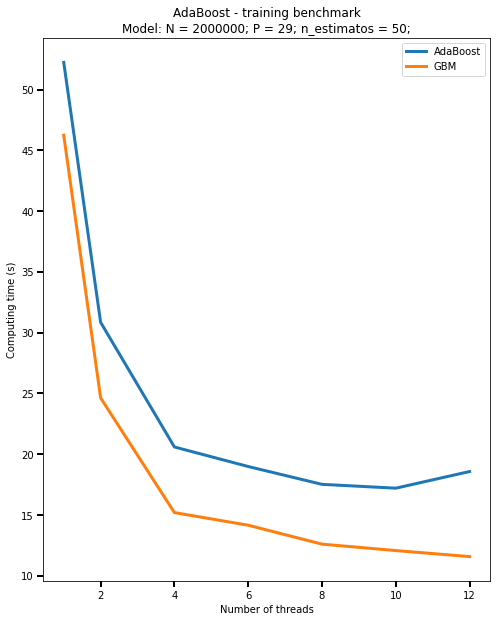

In [7]:
plot_result(adaboost_time, gbm_time)

In [8]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/lending-club/loan.csv", "bad_loan")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx16vc947
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx16vc947\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx16vc947\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_w5fqbk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.808136940002441s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.8574273586273193s
H2O session _sid_93cb closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplrtiaq00
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplrtiaq00\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplrtiaq00\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_hs2ql0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.598735570907593s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.416107416152954s
H2O session _sid_aff3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoyaz1uh7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoyaz1uh7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoyaz1uh7\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_3a2n71
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.366248607635498s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.837385892868042s
H2O session _sid_a903 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl7pbsayw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl7pbsayw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl7pbsayw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_mdwxfv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.253380537033081s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.6071741580963135s
H2O session _sid_b903 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxu8tkip8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxu8tkip8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxu8tkip8\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_5pvui8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.4993369579315186s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 6.8951733112335205s
H2O session _sid_9304 closed.
AdaBoost 6.505167722702026s
IF 5.12265362739563s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7c1g2kdq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7c1g2kdq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7c1g2kdq\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_6qrxj7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.607746124267578s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.535809278488159s
H2O session _sid_9ca3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm94uf8_p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm94uf8_p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm94uf8_p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_3onzfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.563424348831177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.5056111812591553s
H2O session _sid_b221 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzkyvhczc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzkyvhczc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzkyvhczc\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_xdl543
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.883985280990601s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.489428997039795s
H2O session _sid_a12d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm17i52yr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm17i52yr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm17i52yr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_zf6mwf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.293628692626953s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.4894587993621826s
H2O session _sid_88f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbmnlnyaw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbmnlnyaw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbmnlnyaw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_g1zo0f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.524338960647583s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.077976942062378s
H2O session _sid_a05f closed.
AdaBoost 4.3746246814727785s
IF 2.419657039642334s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd4dwj80o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd4dwj80o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd4dwj80o\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_dpo5p5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.092325925827026s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.00913405418396s
H2O session _sid_afe4 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpko0oyj2p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpko0oyj2p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpko0oyj2p\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_d2nzq1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.209799289703369s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.4208579063415527s
H2O session _sid_88d0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprdw36nt3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprdw36nt3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprdw36nt3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_cyyqtg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.5606565475463867s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9618244171142578s
H2O session _sid_aea6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz1tg0pdl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz1tg0pdl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz1tg0pdl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_s5cjpe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 3.522170305252075s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.305246114730835s
H2O session _sid_99ce closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvuk68d_g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvuk68d_g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvuk68d_g\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_g3gr8y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.309726715087891s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.7180113792419434s
H2O session _sid_95a8 closed.
AdaBoost 3.9389357566833496s
IF 2.0830147743225096s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4_zp2euo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4_zp2euo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4_zp2euo\h2o_potte_started_from_python.err
  Server is running at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_v1i3i3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.140132904052734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9199166297912598s
H2O session _sid_a9ad closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplnqfxmh0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplnqfxmh0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplnqfxmh0\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_zrlqlc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.1778600215911865s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.036095380783081s
H2O session _sid_9bab closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp79lr79jn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp79lr79jn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp79lr79jn\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_1c1qhj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.1554224491119385s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9267117977142334s
H2O session _sid_a09e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqkslrtx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqkslrtx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqkslrtx\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_hp1i9r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.05586051940918s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9578518867492676s
H2O session _sid_b747 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxx7oaj06
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxx7oaj06\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxx7oaj06\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_zjlalw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.045711517333984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.966963529586792s
H2O session _sid_968e closed.
AdaBoost 4.114997482299804s
IF 1.9615078449249268s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy0cvv0ea
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy0cvv0ea\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy0cvv0ea\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_ndm55n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0250256061553955s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9359099864959717s
H2O session _sid_a3f3 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpky2r7eml
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpky2r7eml\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpky2r7eml\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at h

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_b4nhnc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.039189100265503s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.352438449859619s
H2O session _sid_a1a0 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl4jz_3vl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl4jz_3vl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl4jz_3vl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_gfgx0u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.024336099624634s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3521478176116943s
H2O session _sid_8953 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6kcxv6q2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6kcxv6q2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6kcxv6q2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_2frg67
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.108434438705444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3582258224487305s
H2O session _sid_9d92 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_k59i25
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_k59i25\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_k59i25\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_y3p8ds
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.0617430210113525s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 1.9512498378753662s
H2O session _sid_a7dc closed.
AdaBoost 4.051745653152466s
IF 2.189994382858276s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp63rs0hdm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp63rs0hdm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp63rs0hdm\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,1 hour and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_3kkdy6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.841978073120117s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3367481231689453s
H2O session _sid_8871 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqx2fhlz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqx2fhlz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqx2fhlz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours
H2O_cluster_name:,H2O_from_python_potte_e48tti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.826019763946533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.833432197570801s
H2O session _sid_a1a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ov3d2iy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ov3d2iy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ov3d2iy\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours
H2O_cluster_name:,H2O_from_python_potte_blppbs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.880538463592529s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.759655475616455s
H2O session _sid_b816 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpztp5g7y4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpztp5g7y4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpztp5g7y4\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_69qd1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.825878858566284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.336878538131714s
H2O session _sid_a1da closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjtaex8zk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjtaex8zk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjtaex8zk\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_vct6wh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.7524402141571045s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.801548957824707s
H2O session _sid_bdda closed.
AdaBoost 5.025371074676514s
IF 2.6136526584625246s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu0p634vy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu0p634vy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu0p634vy\h2o_potte_started_from_python.err
  Server is running at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_z4faqi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.4457106590271s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.41156268119812s
H2O session _sid_8016 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzjfvpuwz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzjfvpuwz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzjfvpuwz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:/

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_68tq7a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.485179901123047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.402137517929077s
H2O session _sid_8932 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp79bft57z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp79bft57z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp79bft57z\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_12j26t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.578073740005493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.3947181701660156s
H2O session _sid_b9be closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcxr6w694
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcxr6w694\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcxr6w694\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_ksvfj7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.531826734542847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.3129138946533203s
H2O session _sid_b086 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5v11hqhz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5v11hqhz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5v11hqhz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_ewehoo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.555115461349487s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.394436836242676s
H2O session _sid_aa4b closed.
AdaBoost 6.5191812992095945s
IF 3.3831538200378417s
12 - AdaBoost = 6.505167722702026, GBM = 5.12265362739563
10 - AdaBoost = 4.3746246814727785, GBM = 2.419657039642334
8 - AdaBoost = 3.9389357566833496, GBM = 2.0830147743225096
6 - AdaBoost = 4.114997482299804, GBM = 1.9615078449249268
4 - AdaBoost = 4.051745653152466, GBM = 2.189994382858276
2 - AdaBoost = 5.025371074676514, GBM = 2.6136526584625246
1 - AdaBoost = 6.5191812992095945, GBM = 3.3831538200378417


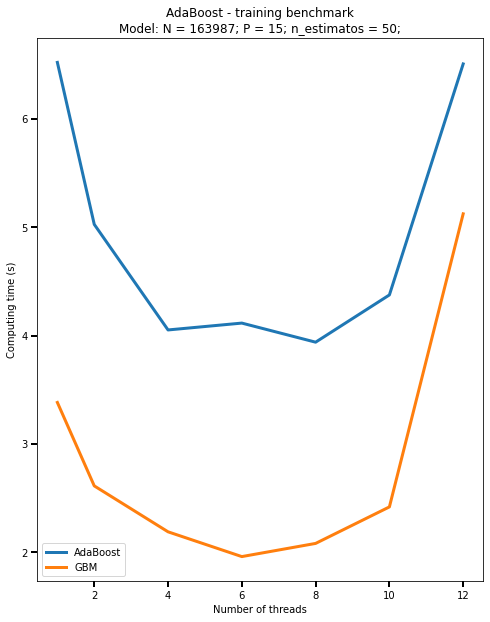

In [9]:
plot_result(adaboost_time, gbm_time)

In [10]:
adaboost_time, gbm_time = run_benchmark(prefix + "/bigdata/laptop/creditcardfraud/creditcardfraud.csv", "Class")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbtclvm3h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbtclvm3h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbtclvm3h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_902yjm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.643439054489136s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.263318777084351s
H2O session _sid_848c closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpskzkapme
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpskzkapme\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpskzkapme\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_dt1bqr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.9309186935424805s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.117016077041626s
H2O session _sid_9815 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyncow0e2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyncow0e2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyncow0e2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_7jnucf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 11.663484811782837s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.741497278213501s
H2O session _sid_9a96 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfi50t1hh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfi50t1hh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfi50t1hh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_dk9p5u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.497874736785889s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 5.407171010971069s
H2O session _sid_93b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfowns1k2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfowns1k2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfowns1k2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_6ukkbp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.74811577796936s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.463289976119995s
H2O session _sid_858d closed.
AdaBoost 7.896766614913941s
IF 4.598458623886108s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8gnomu4j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8gnomu4j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8gnomu4j\h2o_potte_started_from_python.err
  Server is running at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_bgxvuy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.164385795593262s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.372373342514038s
H2O session _sid_8f3a closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2ztjbi1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2ztjbi1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2ztjbi1v\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_olj4qe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.43977165222168s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3424015045166016s
H2O session _sid_8855 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw_dve8wz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw_dve8wz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw_dve8wz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_32vj3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.443024158477783s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.4052951335906982s
H2O session _sid_8f06 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpon9zxyn3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpon9zxyn3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpon9zxyn3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_n6ei9g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.233771324157715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.4741909503936768s
H2O session _sid_85d6 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc7uqz9q5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc7uqz9q5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc7uqz9q5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_mhyj63
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.708257436752319s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3450369834899902s
H2O session _sid_89db closed.
AdaBoost 5.197842073440552s
IF 2.387859582901001s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr091m6o2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr091m6o2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr091m6o2\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_futboh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.175286769866943s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.321098804473877s
H2O session _sid_8364 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpukx0hxdj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpukx0hxdj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpukx0hxdj\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_n45wuv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.910480260848999s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.304810047149658s
H2O session _sid_a393 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmputw_xvuv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmputw_xvuv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmputw_xvuv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_aefqi8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.92487096786499s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3203773498535156s
H2O session _sid_8d4b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4jae47o3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4jae47o3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4jae47o3\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_n0t53m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.072556972503662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3745150566101074s
H2O session _sid_959b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplcun0lej
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplcun0lej\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplcun0lej\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_66ljmq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.127281427383423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.374751329421997s
H2O session _sid_9fb3 closed.
AdaBoost 5.042095279693603s
IF 2.339110517501831s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl1jtw8nj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl1jtw8nj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl1jtw8nj\h2o_potte_started_from_python.err
  Server is running at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_1efekg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.874946117401123s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.7536821365356445s
H2O session _sid_9dcd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_bq_gptv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_bq_gptv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_bq_gptv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_dv15wp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.841941833496094s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.7913818359375s
H2O session _sid_a20b closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpro5htmbv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpro5htmbv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpro5htmbv\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_fj7ytv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 4.924925327301025s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.3051648139953613s
H2O session _sid_9434 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzreofndt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzreofndt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzreofndt\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_lttbh3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.580608367919922s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.320919990539551s
H2O session _sid_9470 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp29kykqes
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp29kykqes\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp29kykqes\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_1eqdlp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.512174606323242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.305642604827881s
H2O session _sid_b300 closed.
AdaBoost 5.146919250488281s
IF 2.4953582763671873s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoz9sqgo2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoz9sqgo2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoz9sqgo2\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_6tkskp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.527315378189087s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.737731456756592s
H2O session _sid_ad7d closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaz0ga_tw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaz0ga_tw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaz0ga_tw\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_b1ciuj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.7536301612854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.722339391708374s
H2O session _sid_8272 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp08ydnotz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp08ydnotz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp08ydnotz\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_0bkl5c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.611953020095825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 3.318803548812866s
H2O session _sid_90c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpufz4p54u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpufz4p54u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpufz4p54u\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_nbf24h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.650431871414185s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.824920415878296s
H2O session _sid_85dd closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprodh40h5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprodh40h5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprodh40h5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_7z1u2c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 5.686784982681274s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 2.775496006011963s
H2O session _sid_89b5 closed.
AdaBoost 5.646023082733154s
IF 2.8758581638336183s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptvkj7r1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptvkj7r1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptvkj7r1v\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_dw5cg4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.4181694984436035s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.793203830718994s
H2O session _sid_80ec closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz19eqvjo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz19eqvjo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz19eqvjo\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_xakbjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.527174711227417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.786299228668213s
H2O session _sid_ab7f closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0oeoxp97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0oeoxp97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0oeoxp97\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_qrzc5x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.384858131408691s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.894842863082886s
H2O session _sid_b0a9 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoc80zcj1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoc80zcj1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoc80zcj1\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_t0urhh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 6.73838472366333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.752223253250122s
H2O session _sid_9c3e closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi84s7mb5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi84s7mb5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi84s7mb5\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_op2757
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 7.40431809425354s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 4.8051605224609375s
H2O session _sid_aa93 closed.
AdaBoost 7.294581031799316s
IF 4.8063459396362305s
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvzre0fq3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvzre0fq3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvzre0fq3\h2o_potte_started_from_python.err
  Server is running at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_a98q7c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.626414060592651s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.545721769332886s
H2O session _sid_b256 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgu5enpln
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgu5enpln\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgu5enpln\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_z4ie6u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.64454197883606s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.533181190490723s
H2O session _sid_be81 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0s4k0d3r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0s4k0d3r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0s4k0d3r\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_55coew
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.66587519645691s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.518880367279053s
H2O session _sid_8760 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptkvcuar2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptkvcuar2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptkvcuar2\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at htt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_zf11tq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.731393814086914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 7.569684028625488s
H2O session _sid_b561 closed.
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.2+8-LTS-86, mixed mode, sharing)
  Starting server from D:\skola\dip\h2o-3\h2o-py\build\main\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk1hhlz3m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk1hhlz3m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk1hhlz3m\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at ht

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.43.0.99999
H2O_cluster_version_age:,2 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_z1s8ep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,23.94 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
adaboost Model Build progress: |█████████████████████████████████████████████████| (done) 100%
AdaBoost Time: 10.950531005859375s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GBM Time: 8.430508852005005s
H2O session _sid_acec closed.
AdaBoost 10.723751211166382s
IF 7.719595241546631s
12 - AdaBoost = 7.896766614913941, GBM = 4.598458623886108
10 - AdaBoost = 5.197842073440552, GBM = 2.387859582901001
8 - AdaBoost = 5.042095279693603, GBM = 2.339110517501831
6 - AdaBoost = 5.146919250488281, GBM = 2.4953582763671873
4 - AdaBoost = 5.646023082733154, GBM = 2.8758581638336183
2 - AdaBoost = 7.294581031799316, GBM = 4.8063459396362305
1 - AdaBoost = 10.723751211166382, GBM = 7.719595241546631


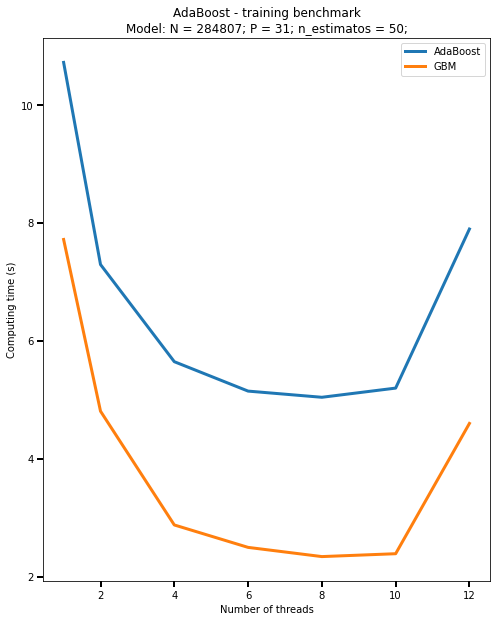

In [11]:
plot_result(adaboost_time, gbm_time)